**Collection Mapper**

This module will assist MV collection system layout design and output a KML file.

> Troubleshooting: Run each cell starting from the beginning, and un-comment print statements to pinpoint the error. 

> Editing: Reference Networkx, SimpleKML, and Python documentation for help making changes. Ask ChatGPT for support as needed.

First-time users will need to install the following libraries: Networkx, Matplotlib, Numpy, tldraw, and SimpleKML. Remove all single quotes and run the following cell.

In [ ]:
'''
import pip
pip.main(["install", "networkx"])
pip.main(["install", "matplotlib"])
pip.main(["install", "numpy"])
pip.main(["install", "tldraw"])
pip.main(["install", "simplekml"])
'''

**Inputs**

**Data Preparation:**
- Load the WTG array KMZ into Global Mapper
- Add the substation as a point feature
- Create coordinate attributes (select all points using the Digitizer and right click > Attribute/Style Functions > Add Coordinates)
- Export CSV (open Layer Attributes to export and use only columns for Feature Name, X, and Y)
>Check sample CSV's if you have trouble with the data format

**In the cell below, enter the following information:**
1. CSV file containing location data: WTG & substation names in the first column, latitude in the second column, logitude in the third column
2. Substation name
3. Number of WTG's per feeder

In [102]:
datafile = 'wtgdata_nimbus.csv'

sub = 'S0'

capacity = 4

Clean the lat/long data exported from Global Mapper, and create a data structure containing the locations of each point.

In [103]:
# Read CSV into a list
import csv
wtg_init = []
with open(datafile) as data:
    D = csv.reader(data, delimiter = ",")
    for row in D:
        wtg_init.append(row)
wtg_init = wtg_init[1:]
#print(wtg_init)

# Format lat/long data: check for quadrant and change type to float
# Create a dictionary data structure to hold coordinates for each point
# Ex. ['S00', '95.13234222? W', '42.00511659? N'] becomes {'S00': (-95.13234222, 42.00511659)}
if 'W' in wtg_init[1][1]:
    if 'N' in wtg_init[1][2]:
        for i in wtg_init:
            i[1] = -1*float(i[1].split('?')[0])
            i[2] = float(i[2].split('?')[0])
    else:
        for i in wtg_init:
            i[1] = -1*float(i[1].split('?')[0])
            i[2] = -1*float(i[2].split('?')[0])
else:
    if 'N' in wtg_init[1][2]:
        for i in wtg_init:
            i[1] = float(i[1].split('?')[0])
            i[2] = float(i[2].split('?')[0])
    else:
        for i in wtg_init:
            i[1] = float(i[1].split('?')[0])
            i[2] = -1*float(i[2].split('?')[0])

pos_dict = {}
for i in wtg_init:
    pos_dict[i[0]] = (float(i[1]),float(i[2]))
print(pos_dict)

if sub not in pos_dict:
    print('\033[1m' + 'Error: Substation name is not included in the input data.' + '\033[0m')

{'S0': (-93.40063433, 36.25723845), 'T10': (-93.41071018, 36.27964444), 'T11': (-93.40545441, 36.27900629), 'T13': (-93.359049, 36.283617), 'T14': (-93.42213179, 36.27368872), 'T15': (-93.41828646, 36.27016105), 'T2': (-93.43481452, 36.29534753), 'T20': (-93.359168, 36.274385), 'T23': (-93.41360381, 36.26263961), 'T24': (-93.39288321, 36.26754885), 'T25': (-93.389494, 36.265397), 'T26': (-93.38493493, 36.26306257), 'T27': (-93.37957222, 36.26146776), 'T28': (-93.37597747, 36.26046992), 'T29': (-93.37153641, 36.26030315), 'T30': (-93.36712861, 36.26077567), 'T33': (-93.35416141, 36.26273921), 'T32': (-93.35774687, 36.26365834), 'T34': (-93.4152868, 36.2555308), 'T35': (-93.40897239, 36.25598079), 'T36': (-93.39490815, 36.25517548), 'T37': (-93.39038905, 36.25601992), 'T39': (-93.407572, 36.238015), 'T4': (-93.43092178, 36.29534399), 'T40': (-93.40282152, 36.2378328), 'T41': (-93.39545119, 36.23917077), 'T42': (-93.399002, 36.224391), 'T45': (-93.39206745, 36.21698462), 'T46': (-93.38954

A weighted graph containing all possible connections in the WTG network is created. Optimal paths will be selected from this graph in the following steps.

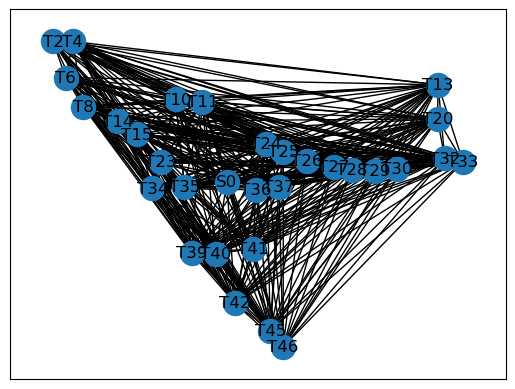

In [20]:
# Create a weighted graph of all possible turbine connections. 
# Weights are calculated as distances between points. 
wtg_network = []
for i in wtg_init:
    for j in wtg_init:
        flag = 0
        if i != j:
            distance =( (float(i[1])-float(j[1]))**2 + (float(i[2])-float(j[2]))**2 )**0.5
            for k in wtg_network:
                if k[0] == j[0] and k[1] == i[0]:
                    flag = 1
            if flag == 0:
                wtg_network.append([i[0],j[0],distance])

import networkx as nx
G = nx.Graph()
G.add_weighted_edges_from(wtg_network)

nx.draw_networkx(G, pos=pos_dict, with_labels=True)

**Sharma's Heuristic for a Capacitated Minimum Spanning Tree with no crossings**

_Sharma RL, El-Bardai MT (1970) Suboptimal communications network synthesis. Proceedings 1970 International Conference on Communications._

1. Calculate angle of all points relative to the substation, and sort
2. Group points in order
3. Add the substation to each group and construct minimum spanning trees
4. Find the version with the minimum weight

[121583.50090368594, 119058.29143500623, 125194.36569182084, 118015.70991495809]
[['T40', 'T42', 'T45', 'T46', 'S0'], ['T41', 'T36', 'T37', 'T29', 'S0'], ['T30', 'T33', 'T28', 'T32', 'S0'], ['T27', 'T26', 'T20', 'T13', 'S0'], ['T25', 'T24', 'T11', 'T10', 'S0'], ['T4', 'T2', 'T6', 'T14', 'S0'], ['T15', 'T8', 'T23', 'T34', 'S0'], ['T35', 'T39', 'S0']]


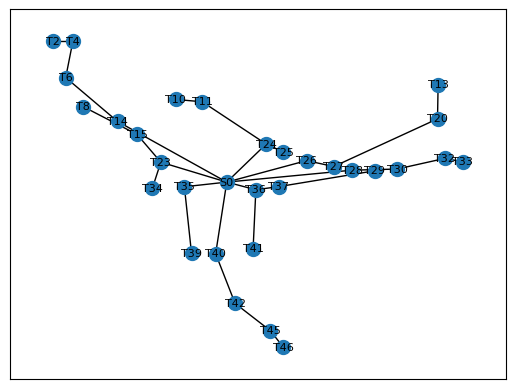

In [94]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import math

# Function to calculate the angle from a center point
def calculate_angle(point, center):
    dx = point[0] - center[0]
    dy = point[1] - center[1]
    angle = math.atan2(dy, dx)
    return angle

# Function to find MST for a list of points
def find_mst_edges(point_list, graph):
    # Create a MST subgraph
    subgraph = graph.subgraph(point_list)
    mst = nx.minimum_spanning_tree(subgraph)
    
    # Extract edges from the MST
    mst_edges = []
    for u, v, data in mst.edges(data=True):
        mst_edges.append([u, v, data['weight']])
    return mst_edges

# Function to find the weight of a graph
def distance_calc(lines):
    total_weight = 0
    for i in lines:
        total_weight += i[2]
    total_weight *= 325000
    return total_weight

# Create a dictionary with angles from the center
center = pos_dict[sub]
angles_dict = {key: calculate_angle(value, center) for key, value in pos_dict.items()}

# Sort the dictionary by angle
sorted_angles = sorted(angles_dict.items(), key=lambda item: item[1])

# Create a list of keys from the sorted dictionary
sorted_keys = [item[0] for item in sorted_angles]
sorted_keys.remove(sub)

# Create list of list of lists containing iterations of Sharma's CMST = capacity
counter = capacity
sharma = []
while counter > 0:
    sharma_versions = [sorted_keys[i:i+capacity] for i in range(0, len(sorted_keys), capacity)]
    sorted_keys = sorted_keys[1:] + [sorted_keys[0]]
    #print(sorted_keys)
    #print(sharma_versions)
    sharma += [sharma_versions]
    counter -= 1
for i in sharma:
    for l in i:
        l.append(sub)

# Find the version with the minimum weight
s_weights = []
for j in sharma:
    s_lines = []
    for i in j:
        s_lines += find_mst_edges(i, G)
    s_weights += [distance_calc(s_lines)]
print(s_weights)

min_s = s_weights.index(min(s_weights))
sharma = sharma.pop(min_s)
print(sharma)
s_lines = []
for i in sharma:
    s_lines += find_mst_edges(i, G)

# Create and draw the graph
G_s = nx.Graph()
for i in sharma:
    G_s.add_weighted_edges_from(s_lines)
nx.draw_networkx(G_s, pos=pos_dict, with_labels=True, node_size=100, font_size = 8)

**Minimum Spanning Tree**

Connects all points along the shortest possible path. By default, the function uses Kruskal's Algorithm.

Minimum Spanning Tree


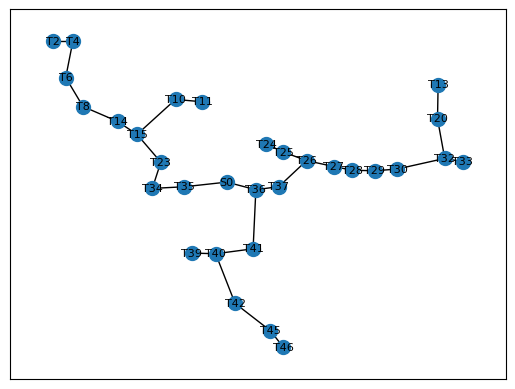

In [83]:
print("Minimum Spanning Tree")
y = nx.minimum_spanning_tree(G)
nx.draw_networkx(y, pos=pos_dict, with_labels=True, node_size=100, font_size = 8)

**Optional Step**

Download PNG from above and upload to the whiteboard tool below to draw WTG groups. Adjust dimensions as needed.

In [26]:
from tldraw import TldrawWidget
t = TldrawWidget(height = 500, width = 800)
t

TldrawWidget(height=500, width=800)

**Input WTG Groups**

Calculate how many WTG's can be connected to each feeder.
For projects with multiple MPT's, put a balanced number of WTG's on each side.

>The names of the turbines and substation must match the names from the CSV file.

In [84]:
# Input collection system here:
collection = {}
collection['11A'] = [sub, 'T36', 'T41', 'T40', 'T39']
collection['11B'] = [sub, 'T2', 'T4', 'T6', 'T8']
collection['12A'] = [sub, 'T14', 'T15', 'T34', 'T35']
collection['12B'] = [sub, 'T11', 'T10', 'T23']

collection['21A'] = [sub, 'T46', 'T45', 'T42']
collection['21B'] = [sub, 'T33', 'T32', 'T30', 'T29']
collection['22A'] = [sub, 'T13', 'T20', 'T28', 'T27']
collection['22B'] = [sub, 'T24', 'T25', 'T26', 'T37']


# Check for incorrect WTG names and duplicates
col_inputs = []
for k in collection:
    for i in collection[k]:
        if i not in pos_dict:
            print(f'{i} is not in the input data.')
        if i not in col_inputs or i is sub:
            col_inputs.append(i)
        else:
            print(f'{i} has duplicate entries.')
#print(col_inputs)

The following cell calculates minimum spanning trees that connect each group of WTG's to the substation. An approximation of the total length is also provided. 

>Return to the previous cell and adjust the WTG groups until you are satisfied with the layout.

Approx. Total Cable Length = 111489.68 ft ± 10%
{'11A': [['T41', 'T40', 0.007490789546490551], ['T41', 'T36', 0.016013920026826816], ['T40', 'T39', 0.004753972767105883], ['T36', 'S0', 0.006086458955195227]], '11B': [['T8', 'T6', 0.008568952926781047], ['T8', 'S0', 0.03491446251265439], ['T6', 'T4', 0.009867615632931787], ['T2', 'T4', 0.003892741609609137]], '12A': [['T34', 'T35', 0.006330423733702259], ['T34', 'T15', 0.01493459658571301], ['T14', 'T15', 0.005218334833809722], ['T35', 'S0', 0.00843237530232126]], '12B': [['T11', 'T10', 0.005294370001738135], ['T10', 'T23', 0.017249270648515405], ['T23', 'S0', 0.014049197159121167]], '21A': [['T46', 'T45', 0.00507624027187692], ['T45', 'T42', 0.010146055805427177], ['S0', 'T42', 0.032887983713383626]], '21B': [['T29', 'T30', 0.00443305492752899], ['T29', 'S0', 0.0292588676201979], ['T30', 'T32', 0.009814623362941357], ['T33', 'T32', 0.003701394786897824]], '22A': [['T13', 'T20', 0.009232766920048865], ['T27', 'T28', 0.003730671819946421

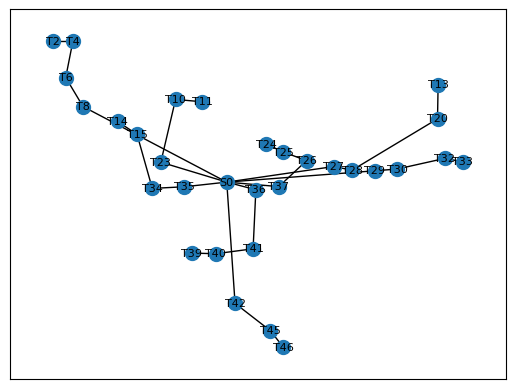

In [85]:
def find_mst_edges(point_list, graph):
    # Create a subgraph with the given points
    subgraph = graph.subgraph(point_list)
    
    # Find the MST of the subgraph
    mst = nx.minimum_spanning_tree(subgraph)
    
    # Extract edges from the MST
    mst_edges = []
    for u, v, data in mst.edges(data=True):
        mst_edges.append([u, v, data['weight']])
    
    return mst_edges

mst_collections = {key: find_mst_edges(points, G) for key, points in collection.items()}
G_mst = nx.Graph()
for k in mst_collections:
    G_mst.add_weighted_edges_from(mst_collections[k])

nx.draw_networkx(G_mst, pos=pos_dict, with_labels=True, node_size=100, font_size = 8)

# Calculate total weight
total_weight = 0
for k in mst_collections:
    for i in mst_collections[k]:
        total_weight += i[2]
total_weight *= 325000
total_weight = round(total_weight, 2)

print('\033[1m' f"Approx. Total Cable Length = {total_weight} ft ± 10%" '\033[0m')
print(mst_collections)

The load_calculator() function is used to calculate the number of WTG's descending from each line segment. This is important for the naming convention of line segments so that the cable schedule will autimatically size the cables.

In [90]:
def load_calculator(edges):
    Gx = nx.Graph()
    Gx.clear()
    
    # Add edges to the graph
    Gx.add_edges_from(edges)

    # Perform BFS starting from substation
    tree = list(nx.dfs_edges(Gx, source= sub))
    #print(tree)

    Gx.clear()
    Gx = nx.DiGraph()
    Gx.add_edges_from(tree)

    # Display the DFS traversal order
    dfs_order = [edge[1] for edge in tree]
    #print("DFS Traversal Order:", dfs_order)

    tree = [list(t) for t in tree]

    for i in dfs_order:
        for j in tree:
            if i == j[1]:
                descendants = len(nx.descendants(Gx,i)) + 1
                j.append(descendants)

    #print(tree)
    return tree

# Copy mst collection, and replace distance with # of WTG's
kml_drawer = mst_collections

for k in kml_drawer:
    kml_drawer[k] = [item[:2] for item in kml_drawer[k]]
 
for k in kml_drawer:
    #print(kml_drawer[k])
    kml_drawer[k] = load_calculator(kml_drawer[k])
print(kml_drawer)

{'11A': [['S0', 'T36', 4], ['T36', 'T41', 3], ['T41', 'T40', 2], ['T40', 'T39', 1]], '11B': [['S0', 'T8', 4], ['T8', 'T6', 3], ['T6', 'T4', 2], ['T4', 'T2', 1]], '12A': [['S0', 'T35', 4], ['T35', 'T34', 3], ['T34', 'T15', 2], ['T15', 'T14', 1]], '12B': [['S0', 'T23', 3], ['T23', 'T10', 2], ['T10', 'T11', 1]], '21A': [['S0', 'T42', 3], ['T42', 'T45', 2], ['T45', 'T46', 1]], '21B': [['S0', 'T29', 4], ['T29', 'T30', 3], ['T30', 'T32', 2], ['T32', 'T33', 1]], '22A': [['S0', 'T27', 4], ['T27', 'T28', 3], ['T28', 'T20', 2], ['T20', 'T13', 1]], '22B': [['S0', 'T37', 4], ['T37', 'T26', 3], ['T26', 'T25', 2], ['T25', 'T24', 1]]}


**Create KML**

The kml_drawer and pos_dict data are used to draw line segments between points.

Folders are named after the feeder.

Line features are named "[Start point] [End point] [# of WTG's]" according to the cable schedule.

The output file will be located in the same folder. Running this script will overwrite the file, so rename it if you want to keep multiple drafts. 

In [89]:
import simplekml
kml = simplekml.Kml()

# Set colors for each feeder
colors = [
    simplekml.Color.tomato,
    simplekml.Color.thistle,
    simplekml.Color.cornflowerblue,
    simplekml.Color.magenta,
    simplekml.Color.gold,
    simplekml.Color.cyan, 
    simplekml.Color.orchid, 
    simplekml.Color.red,
    simplekml.Color.palegreen,
    simplekml.Color.yellow,
    simplekml.Color.olive, 
    simplekml.Color.blue
    ]
line_colors = {}
for k in kml_drawer:
    line_colors[k] = colors[0]
    colors = colors[1:] + [colors[0]]

for layer_desc, lines in kml_drawer.items():
    # Create a folder for each layer
    folder = kml.newfolder(name=layer_desc)
    
    # Iterate over each line in the layer
    for line in lines:
        start, end, attribute = line
        # Get the coordinates from pos_dict
        start_coords = pos_dict[start]
        end_coords = pos_dict[end]
        
        # Create a linestring for each line
        linestring = folder.newlinestring(
            name=f"{start} {end} {attribute}",
            coords=[(start_coords[0], start_coords[1]), (end_coords[0], end_coords[1])]
        )
        
        # Add a description or other attributes if needed
        linestring.description = f"{layer_desc}"
        linestring.style.linestyle.color = line_colors[layer_desc]
        linestring.style.linestyle.width = 2

# Save the KML to a file
kml.save("output.kml")
